In [1]:
import os
import os.path as op
import json
import pandas as pd
from pathlib import Path
import shutil
import logging
import numpy as np
from tqdm import tqdm
from skimage import io
import keras
import math

import tensorflow as tf

from matplotlib import pyplot as plt
import random
random_state = 42
from PIL import Image

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from tensorflow.keras import layers, models, regularizers, callbacks, preprocessing, utils, applications, optimizers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU, MaxPooling2D, Dropout, Flatten, Dense, GlobalMaxPooling2D, Dense, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.applications import efficientnet, vgg16, EfficientNetB0
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.efficientnet import preprocess_input

from google.colab import drive

In [3]:
#pip install tensorflow

In [2]:
# Mount drive to Colab notebook
#drive.flush_and_unmount()
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Uploaded data.zip to my google drive. Now, unzip it and store in 552_project_data folder
# zip_file_path = '/content/drive/MyDrive/Colab Notebooks/data.zip'
# destination_folder = '/content/drive/MyDrive/552_project_data/'
# !unzip "$zip_file_path" -d "$destination_folder"

In [3]:
# Logging configuration
logging.basicConfig(level=logging.INFO,
                    datefmt='%H:%M:%S',
                    format='%(asctime)s | %(levelname)-5s | %(module)-15s | %(message)s')

# IMAGE_SIZE = (299, 299)  # All images contained in this dataset are 299x299 (originally, to match Inception v3 input size)
SEED = 17

# Head directory containing all image subframes. Update with the relative path of your data directory
data_head_dir = Path('/content/drive/MyDrive/552_project_data/data')

# Find all subframe directories
subdirs = [Path(subdir.stem) for subdir in data_head_dir.iterdir() if subdir.is_dir()]
src_image_ids = ['_'.join(a_path.name.split('_')[:3]) for a_path in subdirs]

In [4]:
# Load train/val/test subframe IDs
def load_text_ids(file_path):
    """Simple helper to load all lines from a text file"""
    with open(file_path, 'r') as f:
        lines = [line.strip() for line in f.readlines()]
    return lines

# Load the subframe names for the three data subsets
train_ids = load_text_ids('/content/drive/MyDrive/Colab Notebooks/train_source_images.txt')
validate_ids = load_text_ids('/content/drive/MyDrive/Colab Notebooks/val_source_images.txt')
test_ids = load_text_ids('/content/drive/MyDrive/Colab Notebooks/test_source_images.txt')

# Generate a list containing the dataset split for the matching subdirectory names
subdir_splits = []
for src_id in src_image_ids:
    if src_id in train_ids:
        subdir_splits.append('train')
    elif src_id in validate_ids:
        subdir_splits.append('validate')
    elif(src_id in test_ids):
        subdir_splits.append('test')
    else:
        logging.warning(f'{src_id}: Did not find designated split in train/validate/test list.')
        subdir_splits.append(None)

### Loading and pre processing the data for (224, 244) image size


In [5]:
# Must resize the images and recreate train/test/validation data sets
def load_and_preprocess_v2(img_loc, label):
    def _inner_function_v2(img_loc, label):
      img_loc_str = img_loc.numpy().decode('utf-8')
      img = Image.open(img_loc_str).convert('RGB')
      img = img.resize((224, 224), Image.ANTIALIAS) # resize
      img = np.array(img)
      img = img / 255.0
      label = 1 if label.numpy().decode('utf-8') == 'frost' else 0
      return img, label

    # Wrap the Python function
    X, y = tf.py_function(_inner_function_v2, [img_loc, label], [tf.float32, tf.int64])

    # Set the shape of the tensors
    X.set_shape([224, 224, 3])  # new image size
    y.set_shape([])  # Scalar label
    return X, y

def load_subdir_data(dir_path, image_size, seed=None):
    # Grab only the classes that (1) we want to keep and (2) exist in this directory
    tile_dir = dir_path / Path('tiles')
    label_dir = dir_path /Path('labels')

    loc_list = []

    for folder in os.listdir(tile_dir):
        if os.path.isdir(os.path.join(tile_dir, folder)):
            for file in os.listdir(os.path.join(tile_dir, folder)):
                if file.endswith(".png"):
                    loc_list.append((os.path.join(os.path.join(tile_dir, folder), file), folder))
    return loc_list



IMAGE_SIZE = (224, 224)

# Loop over all subframes, loading each into a list
tf_data_train, tf_data_test, tf_data_val = [], [], []
tf_dataset_train_v2, tf_dataset_test_v2, tf_dataset_val_v2 = [], [], []

# Update the batch and buffer size as per your model requirements
buffer_size = 64
batch_size = 5

for subdir, split in zip(subdirs, subdir_splits):
    full_path = data_head_dir / subdir
    if split=='validate':
        tf_data_val.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split=='train':
        tf_data_train.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split=='test':
        tf_data_test.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))

random.shuffle(tf_data_train)
img_list, label_list = zip(*tf_data_train)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_train_v2= tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_train_v2= tf_dataset_train_v2.map(load_and_preprocess_v2, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_train_v2 = tf_dataset_train_v2.shuffle(buffer_size=buffer_size).batch(batch_size)

random.shuffle(tf_data_val)
img_list, label_list = zip(*tf_data_val)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_val_v2 = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_val_v2 = tf_dataset_val_v2.map(load_and_preprocess_v2, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_val_v2 = tf_dataset_val_v2.shuffle(buffer_size=buffer_size).batch(batch_size)

random.shuffle(tf_data_test)
img_list, label_list = zip(*tf_data_test)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_test_v2 = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_test_v2 = tf_dataset_test_v2.map(load_and_preprocess_v2, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_test_v2 = tf_dataset_test_v2.shuffle(buffer_size=buffer_size).batch(batch_size)

In [6]:
print("Training Dataset Length:", len(tf_dataset_train_v2))
print("Validation Dataset Length:", len(tf_dataset_val_v2))
print("Testing Dataset Length:", len(tf_dataset_test_v2))

Training Dataset Length: 2824
Validation Dataset Length: 1578
Testing Dataset Length: 1595


In [7]:
! pip install tensorflow_addons
import tensorflow_addons as tfa

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 9.2 MB/s eta 0:00:00


In [8]:
def augment(image, label):
    # apply brightness and contrast adjustments
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)

    # apply rotation
    angle = tf.random.uniform([], minval=-math.pi/4, maxval=math.pi/4)
    image = tfa.image.rotate(image, angle)

    # flip left-right
    image = tf.image.random_flip_left_right(image)

    # flip up-down
    image = tf.image.random_flip_up_down(image)

    # adjust hue and saturation
    image = tf.image.random_hue(image, max_delta=0.2)
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)

    return image, label

## d) Transfer Learning

##### In this project, you will use pre-trained models (EfficientNetB0, ResNet50, and VGG16). For these pre-trained networks, you will only train the last fully connected layer, and will freeze all layers before them (i.e. we do not change their parameters during training) and use the outputs of the penultimate layer in the original pre-trained model as the features extracted from each image.

### EfficientNetB0

In [9]:
base_effnet = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_effnet.trainable = False  # Freeze

model_effnet = Sequential([
    base_effnet,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dense(2, activation='softmax')
])

# Compile model with ADAM optimizer and cross entropy loss
model_effnet.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Early stopping with patience = 3 and model checkpointing
early_stop_criteria = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model_res.h5', monitor='val_loss', save_best_only=True)

history_effnet = model_effnet.fit(
    tf_dataset_train_v2,
    epochs=10,
    validation_data=tf_dataset_val_v2,
    callbacks=[early_stop_criteria, checkpoint]
)

# Save model at each epoch
for epoch in range(1, 11):
    model_effnet.save(f'effnet_model_at_epoch_{epoch}.h5')


16705208/16705208 [==============================] - 0s 0us/step
Epoch 1/10
2824/2824 [==============================] - 2638s 923ms/step - loss: 0.6921 - accuracy: 0.6314 - val_loss: 0.8307 - val_accuracy: 0.2310
Epoch 2/10
2824/2824 [==============================] - 1817s 643ms/step - loss: 0.6500 - accuracy: 0.6439 - val_loss: 0.9578 - val_accuracy: 0.2310
Epoch 3/10
2824/2824 [==============================] - 1759s 623ms/step - loss: 0.6454 - accuracy: 0.6472 - val_loss: 0.9152 - val_accuracy: 0.2310
Epoch 4/10
2824/2824 [==============================] - 1707s 604ms/step - loss: 0.6406 - accuracy: 0.6486 - val_loss: 0.9586 - val_accuracy: 0.2310


### Plot the training and validation errors vs. epochs.

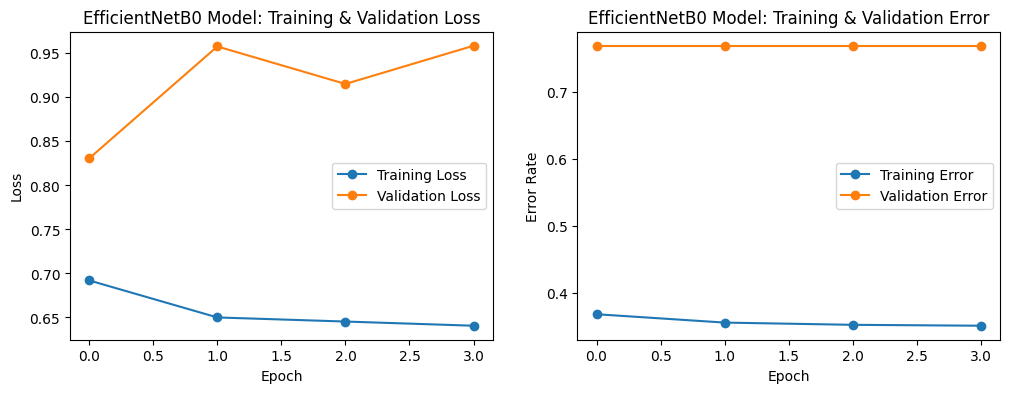

In [10]:
# Error rates
effnet_train_error, effnet_validation_error = [], []

train_accuracy = history_effnet.history['accuracy']
val_accuracy = history_effnet.history['val_accuracy']

for i in range(len(train_accuracy)):
    effnet_train_error.append(1 - train_accuracy[i])
    effnet_validation_error.append(1 - val_accuracy[i])

plt.figure(figsize=(12, 4))

# Training & Validation Loss
plt.subplot(1, 2, 1)
plt.plot(history_effnet.history['loss'], label = 'Training Loss', marker = 'o')
plt.plot(history_effnet.history['val_loss'], label = 'Validation Loss', marker = 'o')
plt.title('EfficientNetB0 Model: Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot for Training and Validation Error
plt.subplot(1, 2, 2)
plt.plot(effnet_train_error, label = 'Training Error', marker = 'o')
plt.plot(effnet_validation_error, label = 'Validation Error', marker = 'o')
plt.title('EfficientNetB0 Model: Training & Validation Error')
plt.xlabel('Epoch')
plt.ylabel('Error Rate')
plt.legend()

plt.show()

### Report Precision, Recall, and F1 score for EfficientNetB0 model.

In [11]:
# best model = least validation loss
best_effnet_model = load_model('best_model_res.h5')

# run model with test data
effnet_predictions = best_effnet_model.predict(tf_dataset_test_v2)
predicted_labels = np.argmax(effnet_predictions, axis=1)

# pull actual Labels from test data
actual_labels = []
for images, labels in tf_dataset_test_v2.unbatch():
    actual_labels.append(labels.numpy())

effnet_report = classification_report(np.array(actual_labels).flatten(), predicted_labels.flatten())
print("EfficientNetB0 Model Classification Report:")
print(effnet_report)

1595/1595 [==============================] - 1043s 645ms/step
EfficientNetB0 Model Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2198
           1       0.72      1.00      0.84      5774

    accuracy                           0.72      7972
   macro avg       0.36      0.50      0.42      7972
weighted avg       0.52      0.72      0.61      7972

